# Gene Expression Analysis Pipeline
This notebook processes gene expression data to identify the top genes that differ most consistently from control means across multiple studies. It then visualizes these differences using PCA.

## ChatGPT prompt
The code was mostly generated by ChatGPT's Data Analyst model. Below is the prompt that I started with:

I have multiple studies with gene expression data. Each Study has one or more families/species under study, indicated by the column 'BREED'. Some samples (indicated by the column 'Experiment'), are Controls, and others are treatments, indicated by the Boolean-valued column 'Control'.

For each sample, use expression counts per million, and filter out genes where CPM < 10 across all samples.

Exclude the Study named Johnson et al. 2020.

Within each BREED within each Study, for each gene_id, find the mean and variance of the expression values of the Control samples. So for each BREED, you'll have mean and variance values for the Control samples. Let's call this control_stats_per_breed.
And then for each non-Control sample within each BREED within each Study, for each gene_id, subtract the gene count from the control_stats_per_breed mean to arrive at difference_from_control_mean for that sample and gene_id.

I now want to take the top 5000 genes that differ most consistently (with the constraint of statistical significance considering variance) including sign (no absolute values) from their respective control_stats_per_breed means across all Studies. Use a variable for 5000 so that it can be easily changed.

Report on how you evaluate that statistical significance and give me a sense of the quality of the consistency across Studies for these 5000 genes.

Perform PCA on these gene-level differences to visualize patterns across studies and families.
I will provide a gene expression matrix and metadata. Please help me process the data in a memory-efficient way, considering that the dataset may be large.

## Steps:
1. Load and preprocess data
2. Compute control statistics
3. Compute differences from control means
4. Perform statistical tests and select top genes
5. Perform PCA and visualize results

## Step 1: Load Data
We first load the metadata and gene expression matrix.

In [1]:
import pandas as pd
import numpy as np
import os
from scipy.stats import ttest_1samp
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load metadata and gene expression data
working_dir = "~/git/Cvirg_Pmarinus_RNAseq/data/"
# === 1️⃣ Load Expression Data (TSV) ===
expression_file = os.path.join(working_dir, "rnaseq_gene_counts", "merged_gene_counts.tsv")
gene_counts = pd.read_csv(expression_file, sep="\t", index_col=0)

# Load the metadata file
metadata_file_path = os.path.join(working_dir, "augmented_metadata.csv")
metadata = pd.read_csv(metadata_file_path)



## Step 2: Preprocess Data
- Compute Counts Per Million (CPM)
- Remove genes with CPM < 10
- Exclude 'Johnson et al. 2020' study

In [2]:
# Compute Counts Per Million (CPM)
library_sizes = gene_counts.sum(axis=0)
cpm = (gene_counts / library_sizes) * 1e6

# Filter out genes with CPM < 10 across all samples
filtered_genes = cpm[(cpm >= 10).any(axis=1)]

# Exclude 'Johnson et al. 2020'
excluded_study = 'Johnson et al. 2020'
samples_to_exclude = metadata[metadata['Study'] == excluded_study]['Experiment'].tolist()

filtered_metadata = metadata[~metadata['Experiment'].isin(samples_to_exclude)]
filtered_gene_counts = filtered_genes.drop(columns=samples_to_exclude, errors='ignore')

## Step 3: Compute Control Statistics
For each `BREED` within each `Study`, compute the mean and variance of control samples.

In [3]:
sample_to_breed_study = filtered_metadata.set_index('Experiment')[['Study', 'BREED', 'control']]
control_samples = sample_to_breed_study[sample_to_breed_study['control'] == 1].index

# Compute mean and variance for control samples
control_stats_per_breed = (
    filtered_gene_counts[control_samples]
    .T.join(sample_to_breed_study, how='left')
    .groupby(['Study', 'BREED'])
    .agg(['mean', 'var'])
)
control_stats_per_breed = control_stats_per_breed.swaplevel(axis=1)
control_stats_per_breed.describe()
print(f"Genes with 'var' values: {(control_stats_per_breed.xs('var', level=0, axis=1).count() > 0).sum()}")

Genes with 'var' values: 26077


In [4]:
print("Shape of control_stats_per_breed:", control_stats_per_breed.shape)



Shape of control_stats_per_breed: (9, 52154)


## Step 4: Compute Differences from Control Means
For each non-control sample, subtract the control mean for its corresponding `BREED`.

In [5]:
differences = []
non_control_samples = sample_to_breed_study[sample_to_breed_study['control'] == 0].index

for (study, breed), group in sample_to_breed_study.loc[non_control_samples].groupby(['Study', 'BREED']):
    if (study, breed) in control_stats_per_breed.index:
        control_means = control_stats_per_breed.loc[(study, breed)]['mean']
        samples = group.index
        subset = filtered_gene_counts.loc[:, samples]
        difference_from_control_mean = subset.sub(control_means, axis=0)
        differences.append(difference_from_control_mean)


In [6]:

differences_df = pd.concat(differences, axis=1)
print(f"Genes in differences_df: {differences_df.shape[0]}")
print("Summary of differences_df before standardization:")
print(differences_df.describe())


Genes in differences_df: 26077
Summary of differences_df before standardization:
Experiment   SRX13037863   SRX13037862   SRX13037868   SRX13037867  \
count       26076.000000  26076.000000  26076.000000  26076.000000   
mean           -0.014946     -0.016286      0.028184     -0.007796   
std            71.156633     77.326078     26.132130     29.437779   
min         -4511.411609  -4600.168350  -1087.453042  -1343.038228   
25%            -0.433343     -0.368909     -2.041251     -1.809849   
50%             0.000000      0.000000     -0.089956     -0.030470   
75%             2.046223      2.298725      1.347345      1.590633   
max          1850.417130   2640.922437   1649.891400   1360.359177   

Experiment    SRX7172559    SRX7172524    SRX7172558    SRX7172522  \
count       26076.000000  26076.000000  26076.000000  26076.000000   
mean           -0.005630      0.011466      0.010501      0.003523   
std            73.298297     65.538384    102.706812    104.193709   
min     

In [7]:

print(f"Total genes in differences_df: {len(differences_df)}")
print(f"Genes with at least one non-null value: {(differences_df.count(axis=1) > 0).sum()}")

Total genes in differences_df: 26077
Genes with at least one non-null value: 26076


## Step 5: Perform Statistical Tests
We standardize the differences using control variance and perform one-sample t-tests.

In [8]:
import numpy as np
import pandas as pd
from scipy.stats import ttest_1samp, combine_pvalues

# Compute control standard deviation
control_variance = control_stats_per_breed.xs("var", level=0, axis=1)
control_std = np.sqrt(control_variance.replace(0, np.nan))


In [10]:
control_std = control_std.T  # Transpose so genes become rows

In [11]:
print(f"Shape of control_std before reindexing: {control_std.shape}")
print(f"Shape of differences_df: {differences_df.shape}")


Shape of control_std before reindexing: (26077, 9)
Shape of differences_df: (26077, 109)


In [12]:

aligned_control_std = control_std.copy()

In [ ]:
aligned_control_std = aligned_control_std.replace({0: np.nan}).fillna(1e-6)

# Debugging: Check data shapes with expected matches
print(f"Shape of control_variance: {control_variance.shape} (expected: (n_breeds, n_genes))")
print(f"Shape of control_std: {control_std.shape} (expected: (n_genes, n_breeds))")
print(f"Shape of aligned_control_std: {aligned_control_std.shape} (expected: same as differences_df)")
print(f"Shape of differences_df: {differences_df.shape} (expected: (n_genes, n_samples)))")


Shape of control_variance: (9, 26077) (expected: (n_genes, n_breeds))
Shape of control_std: (26077, 9) (expected: (n_genes, n_breeds))
Shape of aligned_control_std: (26077, 9) (expected: same as differences_df)
Shape of differences_df: (26077, 109) (expected: (n_genes, n_samples)))


In [27]:

# Compute standardized effect size
differences_df = differences_df.astype(np.float32)  # Ensure memory efficiency

print("Index name of differences_df:", differences_df.index.name)
print("Index name of aligned_control_std:", aligned_control_std.index.name)

print("Sample gene names in differences_df:", differences_df.index[:5].tolist())
print("Sample gene names in aligned_control_std:", aligned_control_std.index[:5].tolist())

common_genes = differences_df.index.intersection(aligned_control_std.index)
print(f"Number of overlapping genes: {len(common_genes)} (expected: {differences_df.shape[0]})")

differences_df.index.name = "gene_id"
aligned_control_std.index.name = "gene_id"
print(f"Index name of differences_df: {differences_df.index.name}")
print(f"Index name of aligned_control_std: {aligned_control_std.index.name}")
print(f"Index dtype of differences_df: {differences_df.index.dtype}")
print(f"Index dtype of aligned_control_std: {aligned_control_std.index.dtype}")
print(f"Are indices equal? {differences_df.index.equals(aligned_control_std.index)}")

print("Sample column names in differences_df:", differences_df.columns[:5])
print("Sample column names in aligned_control_std:", aligned_control_std.columns[:5])



Index name of differences_df: gene_id
Index name of aligned_control_std: gene_id
Sample gene names in differences_df: ['LOC111099029', 'LOC111099030', 'LOC111099033', 'LOC111099035', 'LOC111099036']
Sample gene names in aligned_control_std: ['LOC111099029', 'LOC111099030', 'LOC111099033', 'LOC111099035', 'LOC111099036']
Number of overlapping genes: 26077 (expected: 26077)
Index name of differences_df: gene_id
Index name of aligned_control_std: gene_id
Index dtype of differences_df: object
Index dtype of aligned_control_std: object
Are indices equal? True
Sample column names in differences_df: Index(['SRX13037863', 'SRX13037862', 'SRX13037868', 'SRX13037867',
       'SRX7172559'],
      dtype='object', name='Experiment')
Sample column names in aligned_control_std: MultiIndex([('Chan et al. 2021',        'Crassostrea gigas'),
            ('Chan et al. 2021',    'Crassostrea virginica'),
            (        'P&S 2020', 'ABC_VIMS_Family_2014_242'),
            (        'P&S 2020', 'ABC_VI

In [83]:
# Map each sample to its BREED
breed_mapping = filtered_metadata.set_index("Experiment")["BREED"]

# Expand aligned_control_std to match sample structure
sample_breeds = filtered_metadata.set_index("Experiment")[["Study", "BREED"]]  # Keep Study and BREED
sample_breeds = sample_breeds.reindex(differences_df.columns)  # Align with sample order

# Check unique BREED names from both sources
print("Unique BREEDs in aligned_control_std:", set(aligned_control_std.columns))
# Convert sample_breeds to a MultiIndex that matches aligned_control_std
# Convert DataFrame rows into a list of tuples
sample_breeds_tuples = list(map(tuple, sample_breeds.values))
# Create MultiIndex
sample_breeds_index = pd.MultiIndex.from_tuples(sample_breeds_tuples, names=["Study", "BREED"])

# Reindex using the full MultiIndex
expanded_control_std = aligned_control_std.reindex(columns=sample_breeds_index, fill_value=np.nan)
print("First few MultiIndex tuples in sample_breeds_index:", sample_breeds_index[:5])
print("Does sample_breeds_index match aligned_control_std.columns?:", set(sample_breeds_index).issubset(set(aligned_control_std.columns)))

# Perform division safely
standardized_differences = differences_df.div(expanded_control_std.values)
print("Shape of expanded_control_std:", expanded_control_std.shape)
print("Percentage of NaNs in expanded_control_std:", expanded_control_std.isna().mean().mean() * 100, "%")
print("First few columns of expanded_control_std:", expanded_control_std.columns[:5])

# Debugging: Check shapes
print(f"Shape of differences_df: {differences_df.shape}")
print(f"Shape of expanded_control_std: {expanded_control_std.shape} (expected: same as differences_df)")
print(f"Shape of standardized_differences: {standardized_differences.shape} (expected: same as differences_df)")

# standardized_differences = differences_df.div(aligned_control_std)

# Debugging: Check standardized differences shape
print(f"Shape of standardized_differences: {standardized_differences.shape} (expected: same as differences_df)")


Unique BREEDs in aligned_control_std: {('P&S 2020', 'ABC_VIMS_Family_2014_242'), ('P&S 2020', 'ABC_VIMS_Family_2014_266'), ('Chan et al. 2021', 'Crassostrea virginica'), ('Chan et al. 2021', 'Crassostrea gigas'), ('P&S 2023', 'ABC_VIMS_Family_2017120'), ('P&S 2023', 'ABC_VIMS_Family_2017089'), ('P&S 2021', 'ABC_VIMS_Family_2014_286'), ('P&S 2023', 'ABC_VIMS_Family_2017090'), ('P&S 2023', 'ABC_VIMS_Family_2017084')}
First few MultiIndex tuples in sample_breeds_index: MultiIndex([('Chan et al. 2021',        'Crassostrea gigas'),
            ('Chan et al. 2021',        'Crassostrea gigas'),
            ('Chan et al. 2021',    'Crassostrea virginica'),
            ('Chan et al. 2021',    'Crassostrea virginica'),
            (        'P&S 2020', 'ABC_VIMS_Family_2014_242')],
           names=['Study', 'BREED'])
Does sample_breeds_index match aligned_control_std.columns?: True
Shape of expanded_control_std: (26077, 109)
Percentage of NaNs in expanded_control_std: 0.0 %
First few columns of 

In [ ]:

# Group data by Study
# study_groups = list(standardized_differences.T.groupby(filtered_metadata.set_index("Experiment")["Study"]))
study_groups = []
for study, study_df in filtered_metadata.groupby("Study"):
    matching_samples = study_df["Experiment"].values  # Get sample IDs
    valid_samples = [s for s in matching_samples if s in standardized_differences.columns]  # Filter only valid samples
    study_data = standardized_differences[valid_samples]  # Select samples as columns
    if not study_data.empty:
        study_groups.append((study, study_data))

print(f"Total study groups: {len(study_groups)}")
for study, df in study_groups[:5]:  # First 5 studies
    print(f"Study: {study} | Shape: {df.shape} | First 5 columns (samples): {df.columns[:5].tolist()}")


# Compute meta-analysis statistics for each gene
# Function to compute effect size and heterogeneity per gene
def meta_analysis_per_gene(gene_id, study_groups):
    effect_sizes = []
    variances = []
    p_values = []

    for study, df in study_groups:
        if gene_id in df.index:
            values = df.loc[gene_id].dropna().values
            if len(values) > 1:
                t_stat, p_val = ttest_1samp(values, 0, nan_policy="omit")
                mean_effect = np.mean(values)
                var_effect = np.var(values, ddof=1)

                effect_sizes.append(mean_effect)
                variances.append(var_effect)
                p_values.append(p_val)

    if len(effect_sizes) < 2:
        return np.nan, np.nan, np.nan, np.nan

    weights = 1 / np.array(variances)
    weighted_mean = np.sum(weights * np.array(effect_sizes)) / np.sum(weights)
    Q_stat = np.sum(weights * (np.array(effect_sizes) - weighted_mean) ** 2)
    I_squared = max(0, (Q_stat - (len(effect_sizes) - 1)) / Q_stat) * 100 if Q_stat > 0 else 0

    if len(p_values) > 1:
        combined_p_value = combine_pvalues(p_values)[1]
    else:
        combined_p_value = p_values[0]

    return weighted_mean, Q_stat, I_squared, combined_p_value
meta_analysis_results = {}
for gene_id in standardized_differences.index:
    meta_analysis_results[gene_id] = meta_analysis_per_gene(gene_id, study_groups)

# Convert results to DataFrame
meta_df = pd.DataFrame.from_dict(meta_analysis_results, orient="index",
                                 columns=["weighted_mean", "Q_stat", "I_squared", "combined_p_value"])

# Debugging: Check meta-analysis DataFrame shape
print(f"Shape of meta_df: {meta_df.shape} (expected: (n_genes, 4))")


Total study groups: 4
Study: Chan et al. 2021 | Shape: (26077, 4) | First 5 columns (samples): ['SRX13037868', 'SRX13037867', 'SRX13037863', 'SRX13037862']
Study: P&S 2020 | Shape: (26077, 30) | First 5 columns (samples): ['SRX7172559', 'SRX7172553', 'SRX7172552', 'SRX7172524', 'SRX7172558']
Study: P&S 2021 | Shape: (26077, 26) | First 5 columns (samples): ['SRX9845543', 'SRX9845542', 'SRX9845541', 'SRX9845540', 'SRX9845511']
Study: P&S 2023 | Shape: (26077, 49) | First 5 columns (samples): ['SRX18040064', 'SRX18040062', 'SRX18040061', 'SRX18040060', 'SRX18040059']


In [87]:
print(f"Number of study groups: {len(study_groups)}")
for i, (study, df) in enumerate(study_groups[:5]):  # Show first 5
    print(f"Study: {study}, Shape of study data: {df.shape}")


Number of study groups: 4
Study: Chan et al. 2021, Shape of study data: (26077, 4)
Study: P&S 2020, Shape of study data: (26077, 30)
Study: P&S 2021, Shape of study data: (26077, 26)
Study: P&S 2023, Shape of study data: (26077, 49)


Summary statistics for meta_df:
       weighted_mean        Q_stat     I_squared  combined_p_value
count   25193.000000  25193.000000  26076.000000      2.522400e+04
mean        0.065896      1.246224      2.980318      8.209545e-02
std        24.842573      3.859568     11.518881      1.779455e-01
min        -2.035642      0.001153      0.000000      0.000000e+00
25%        -0.269649      0.327844      0.000000      4.178523e-07
50%        -0.111925      0.668186      0.000000      1.263770e-03
75%         0.077659      1.420246      0.000000      5.795131e-02
max      3942.707999    551.264627     99.455797      9.997429e-01
Number of genes with p-value < 0.05: 18604
Number of genes with I² < .001: 23762
I-squared min: 0.0


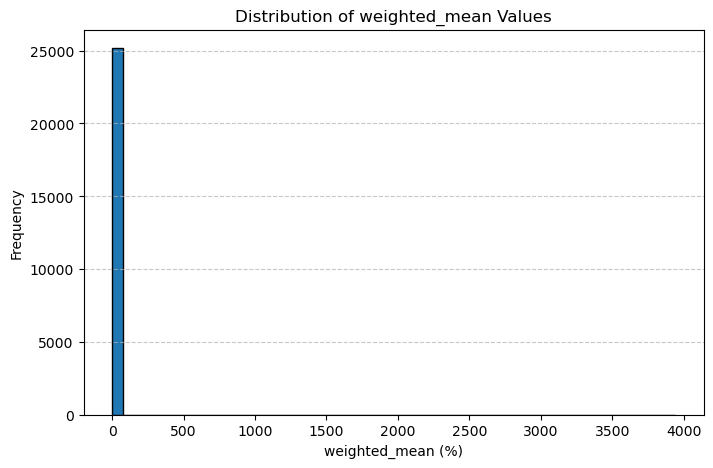

In [117]:
print("Summary statistics for meta_df:")
print(meta_df.describe())

print(f"Number of genes with p-value < 0.05: {(meta_df['combined_p_value'] < 0.05).sum()}")
print(f"Number of genes with I² < .001: {(meta_df['I_squared'] < .001).sum()}")
isquared_median = meta_df["I_squared"].min()
print(f"I-squared min: {isquared_median}")
plt.figure(figsize=(8, 5))
plt.hist(meta_df["weighted_mean"].dropna(), bins=50, edgecolor="black")  # Drop NaNs before plotting
plt.xlabel("weighted_mean (%)")
plt.ylabel("Frequency")
plt.title("Distribution of weighted_mean Values")
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.show()


In [109]:

# Apply filters: select genes with significant deviation AND reasonable heterogeneity
selected_genes = meta_df[
    (meta_df["combined_p_value"] < 0.05) &  # Looser significance threshold
    (meta_df["I_squared"] < 0.000000000001)  # Allow moderate variation
].nsmallest(1000, "I_squared").index

# Debugging: Check selected genes count
print(f"Number of selected genes: {len(selected_genes)} (expected: <= 5000)")



Number of selected genes: 1000 (expected: <= 5000)


## Step 6: PCA and Visualization
Perform PCA on the top N genes to visualize differences across samples.

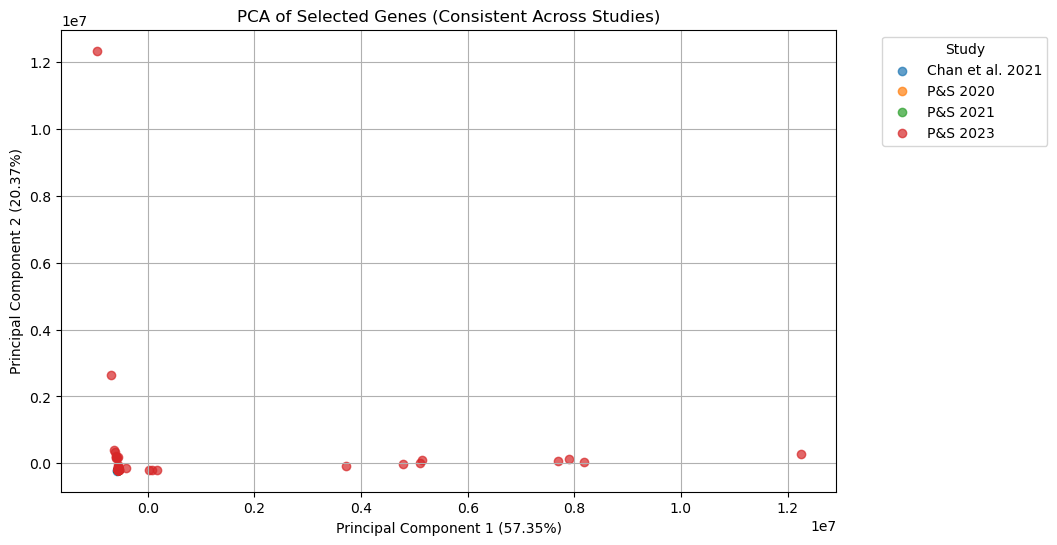

Shape of PCA data: (109, 13)
Number of unique samples in PCA data: 13


In [96]:

# Define markers for traits
trait_markers = {"sensitive": "x", "tolerant": "o"}

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Subset data to selected genes
top_gene_differences = standardized_differences.loc[selected_genes].dropna(axis=1, how="any")

# Convert data to float32 for memory efficiency
top_gene_differences = top_gene_differences.astype(np.float32)

# Perform PCA
pca = PCA(n_components=2)
pca_result = pca.fit_transform(top_gene_differences.T)  # Transpose so samples are rows

# Compute explained variance for axis labels
explained_variance = pca.explained_variance_ratio_ * 100

# Create DataFrame for visualization
pca_df = pd.DataFrame(pca_result, columns=["PC1", "PC2"], index=top_gene_differences.columns)
pca_df = pca_df.join(filtered_metadata.set_index("Experiment"))

# Plot PCA colored by Study
plt.figure(figsize=(10, 6))
for study in pca_df["Study"].unique():
    subset = pca_df[pca_df["Study"] == study]
    plt.scatter(subset["PC1"], subset["PC2"], label=study, alpha=0.7)

# Update axis labels to include variance explained
plt.xlabel(f"Principal Component 1 ({explained_variance[0]:.2f}%)")
plt.ylabel(f"Principal Component 2 ({explained_variance[1]:.2f}%)")
plt.title("PCA of Selected Genes (Consistent Across Studies)")

# Adjust legend
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title="Study")
plt.grid(True)
plt.show()

print(f"Shape of PCA data: {pca_df.shape}")  # Should be (n_samples, n_components)
print(f"Number of unique samples in PCA data: {len(set(map(tuple, pca_df)))}")
